In [1]:
!pip install pydicom
!mkdir data
import shutil

shutil.copy('../content/IMG-0002-00001.dcm', '../content/data/IMG-0002-00001.dcm')

    100% |████████████████████████████████| 7.0MB 4.3MB/s 


'../content/data/IMG-0002-00005.dcm'

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import imageio

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '../content/data/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [0]:
# Load the scans in given folder path
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [0]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

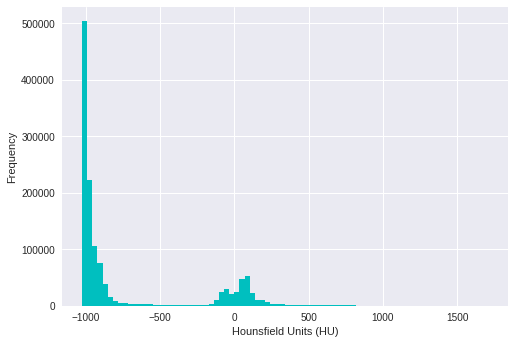

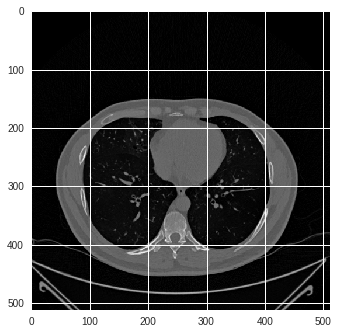

In [5]:
first_patient = load_scan(INPUT_FOLDER)
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[0], cmap=plt.cm.gray)
plt.show()  

In [0]:
xMin, yMin, xMax, yMax = 302, 316, 318, 334
# xMin, yMin, xMax, yMax = 170, 305, 190, 330

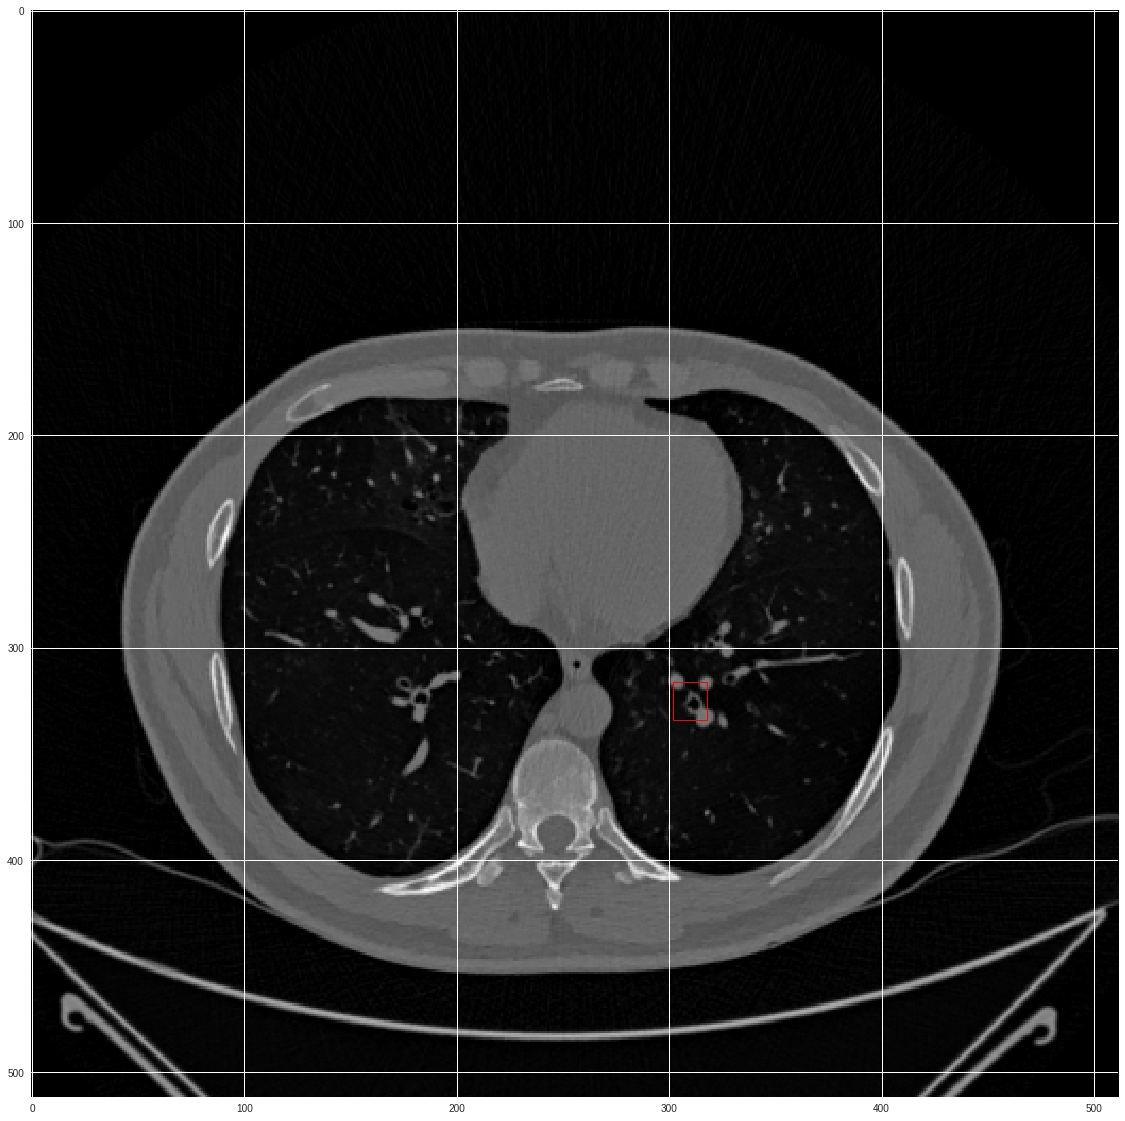

In [8]:
fig,ax = plt.subplots(1,figsize=(20,20))
ax.imshow(first_patient_pixels[0], cmap='gray')
rect = patches.Rectangle((xMin,yMin),abs(xMin-xMax),abs(yMin - yMax),linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [0]:
ROI = first_patient_pixels[0][yMin:yMax+1, xMin:xMax+1]

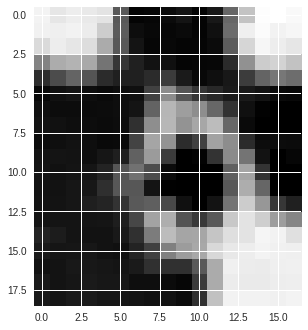

In [10]:
plt.imshow(ROI, cmap='gray')

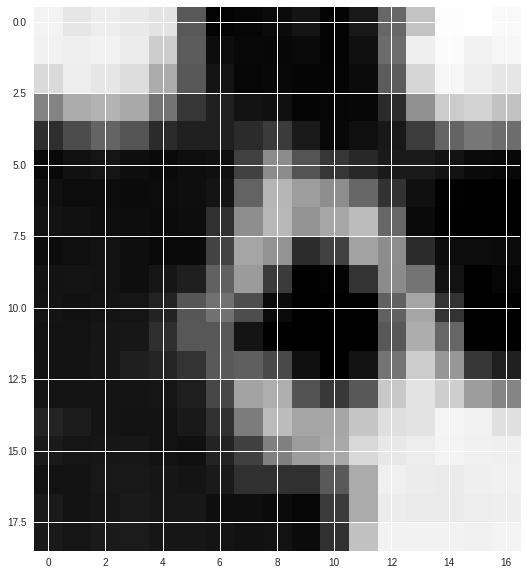

In [11]:
fig,ax = plt.subplots(1,figsize=(10,10))
ax.imshow(ROI, cmap='gray')
for cords in ROI:
  circle = patches.Circle((cords[0],cords[1]),radius=0.2,color='r')
#   print(circle)
  ax.add_patch(circle)
# plt.show()

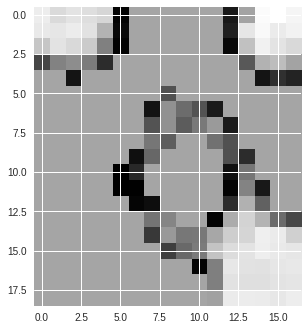

In [12]:
ROI2 = ROI
ROI2[ROI<ROI2.mean()] = 0 
# all pixels with range lower than mean value set to zero
plt.imshow(ROI2, cmap='gray')

In [0]:
list_of_candidates = [] 
ROI_size = ROI2.shape
for i in range(ROI_size[0]):
    for j in range(ROI_size[1]):
        if ROI2[i,j] == 0:
            list_of_candidates.append((i,j))

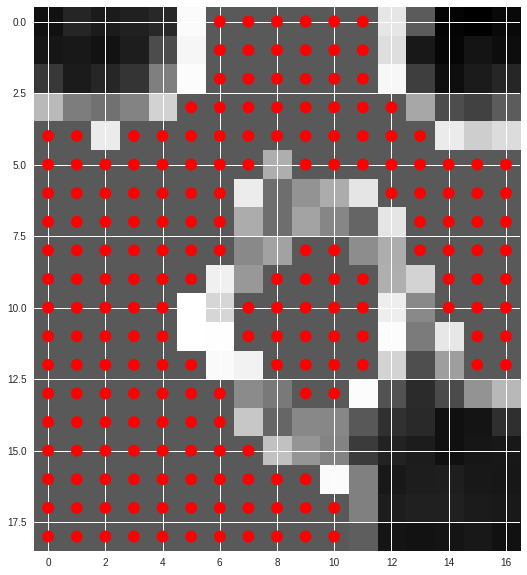

In [14]:
# show all zero pixels
fig,ax = plt.subplots(1,figsize=(10,10))
ax.imshow(ROI2, cmap='binary')
for cords in list_of_candidates:
  circle = patches.Circle((cords[1],cords[0]),radius=0.2,color='r')
#   print(circle)
  ax.add_patch(circle)
# plt.show()

In [0]:
# find the neighbours of zero pixels with 4 borders to find bronchus area
X,Y=ROI2.shape
inner_points_x = []
inner_points_y = []
inner_points = []
for x in range(X):
  for y in range(Y):
    
    if ROI2[x][y] == 0: # if it is zero
      borders = 0
      for i in range(0,x):
        if ROI2[i][y] != 0:
          borders += 1
          break
      for i in range(x,X):
        if ROI2[i][y] != 0:
          borders += 1
          break
      for j in range(0,y):
        if ROI2[x][j] != 0:
          borders += 1
          break
      for j in range(y,Y):
        if ROI2[x][j] != 0:
          borders += 1
          break
      if borders == 4: # if there is 4 borders
        inner_points_x.append(x)
        inner_points_y.append(y)
        inner_points.append([x,y])


In [0]:
x5=round(sum(inner_points_x)/len(inner_points_x)) 
y5=round(sum(inner_points_y)/len(inner_points_y))

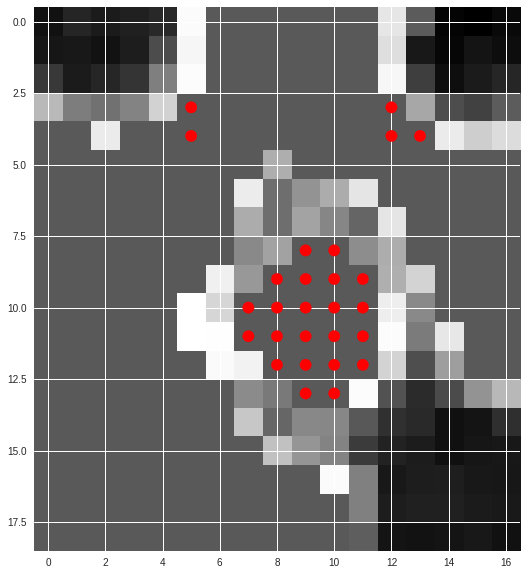

In [17]:
# show all pixels neighbours
fig,ax = plt.subplots(1,figsize=(10,10))
for cords in inner_points:
  circle = patches.Circle((cords[1],cords[0]),radius=0.2,color='r')
  ax.add_patch(circle)
ax.imshow(ROI2, cmap='binary')

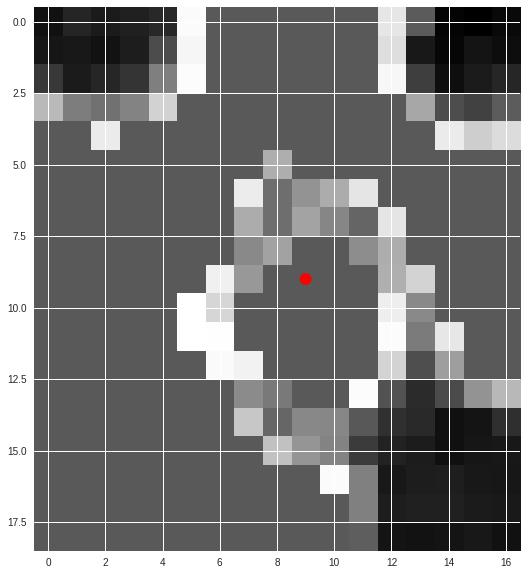

In [18]:
# show the bronchus center
fig,ax = plt.subplots(1,figsize=(10,10))
ax.imshow(ROI2, cmap='binary')
circle = patches.Circle((y5,x5),radius=0.2,color='r')
ax.add_patch(circle)
plt.show()